# Machine Learning Engineer Nanodegree
## Capstone Project
## Project 5: Negotiating Buying a Home  

My project is to utilize machine learning to predict how much to negotiate on a house you’re considering purchasing.  The idea came to me when a friend of mine asked me to help her come up with a price for a house she wanted to bid on.  Many sites such as Zillow already provide an estimate of a house’s worth based on their own proprietary formula.  However, these estimates can be substantially different than the price the seller wants to ask for.   

## Getting Started

The data set was compiled and prepared by my friend’s realtor.  The data contains recent sales of homes within a 5-mile radius of the home she was looking to purchase.  It came directly from the multiple listing service (MLS).  The MLS database allows real estate brokers to share their listings with one another for the purpose of locating ready, willing, and able buyers more efficiently.  This database is only accessible by professional real estate agents.  I’m considering turning this project into an app in the future.    

<b>Features</b>
- #Bedrooms – number of bedrooms in the home 
- #Baths – number of bathrooms in the home
- #Rooms – total number of rooms in the home
- #Fin SF – total size of the house in square feet
- List Price – the price the seller wants to sell the home for 
- Sales Price – the price the home actually sells for 
- Days On Markets – number of days the home has listed for sale on the market before being sold 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
%matplotlib inline

try:
    data = pd.read_csv("data.csv")
    data = data.drop(['PID', 'Status', 'Address', 'Subdivision'], axis = 1)
    print "Dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Dataset has 237 samples with 7 features each.


## Data Preprocessing
In this section, we will preprocess the data by cleaning data and removing outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.  We might need to scale the data if the data is not normally distributed.  Finally, we will need to determine which feature and target columns.  

In [2]:
display(data.describe())

,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,3.379747,2.028692,7.143460,1728.198312,209015.852321,205513.438819,40.172996
std,0.543929,0.354779,1.335821,362.655260,44913.470624,43375.273253,45.701496
min,3.000000,1.000000,5.000000,0.000000,107900.000000,102000.000000,1.000000
25%,3.000000,2.000000,6.000000,1518.000000,174900.000000,174000.000000,8.000000
50%,3.000000,2.100000,7.000000,1660.000000,209950.000000,205000.000000,24.000000
75%,4.000000,2.100000,8.000000,1896.000000,238950.000000,235000.000000,56.000000
max,5.000000,3.000000,12.000000,3135.000000,375950.000000,355000.000000,384.000000


### Implementation: Data Cleaning

We need to clean the data before we can do any analysis.  The minimum value for Fin SF is 0.  This is already a problem since a home cannot have Fin SF of zero for its size.  All the values in each column must be greater than zero.  Therefore, any row that contains values less than 1 will be removed.  Rows with null values will be removed as well.  Finally, we make sure that # Rooms is at least equal to the sum of # of Bedrooms and # Baths.  Four bad data points have been removed from the data set because they were either null, less than 1, or are inconsistent.    

In [3]:
zero_or_negative = []
for i, r in data.iterrows():
    for c in data.columns:
        if r[c] <= 0:
            zero_or_negative.append(i)  

data = data.dropna().drop(data.index[zero_or_negative].unique())
data = data[data['# Rooms'] - data['# Bedrooms'] - data['# Baths'] >= 0]
data = data.reset_index(drop = True)
display(data.describe())

,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,3.376068,2.023932,7.158120,1735.910256,209309.217949,205768.098291,40.213675
std,0.543814,0.351245,1.338036,346.664927,44735.681218,43217.123404,45.927696
min,3.000000,1.000000,5.000000,1016.000000,107900.000000,102000.000000,1.000000
25%,3.000000,2.000000,6.000000,1518.500000,174950.000000,174950.000000,8.250000
50%,3.000000,2.100000,7.000000,1662.000000,209950.000000,205000.000000,23.500000
75%,4.000000,2.100000,8.000000,1899.000000,238587.500000,235000.000000,56.000000
max,5.000000,3.000000,12.000000,3135.000000,375950.000000,355000.000000,384.000000


#### Observations: 

4 bad data points have been removed from the data set, because they were either null, less than 1, or are inconsistent.    

### Implementation: Outlier Removal
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identifying outliers] (http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.  The data points that had more than one outlier per feature were removed. Those data points are more likely to be irregularities since there were outliers found in multiple features. They should be removed because regression models are sensitive to outliers.

In [4]:
# For each feature find the data points with extreme high or low values
index_to_outliers = {}
for feature in data.keys():
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = data[feature].quantile(0.25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = data[feature].quantile(0.75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outliers = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))] 
    display(outliers)
    
    for i in outliers.index.tolist():
        if i in index_to_outliers:
            index_to_outliers[i] += 1
        else:
            index_to_outliers[i] = 1
    
filtered_dict = {k:v for k,v in index_to_outliers.iteritems() if v > 1}
    
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = [filtered_dict.keys()]

# Remove the outliers, if any were specified
data = data.drop(data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature '# Bedrooms':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market


Data points considered outliers for the feature '# Baths':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
2,3,1.1,7,1520,107900,110000,12
3,3,1.0,5,1188,109270,109270,8
4,3,1.1,6,1422,124000,102000,69
5,3,1.1,5,1362,129950,131500,6
11,3,1.1,6,1362,135000,132500,5
15,3,1.1,6,1416,149900,143000,111
23,3,1.1,6,1520,151950,152000,3
29,3,3.0,7,1600,159950,168000,112
43,3,1.1,5,1362,167900,160500,101
45,3,1.1,6,1362,169500,165000,37


Data points considered outliers for the feature '# Rooms':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
233,5,2.1,12,3135,375950,355000,162


Data points considered outliers for the feature 'Fin SF':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
159,4,2.1,8,2475,229950,229950,36
163,5,3.0,10,2492,232500,230000,171
213,5,3.0,8,3014,269950,271950,5
215,4,2.1,10,2548,269950,265000,157
227,5,2.1,10,2500,300000,295000,37
228,4,2.1,9,2500,319000,315000,57
229,4,2.1,8,2649,319900,319900,7
230,4,2.1,9,2600,323900,310000,46
231,4,2.1,9,2498,324500,300000,12
232,4,2.1,8,2762,335000,325000,12


Data points considered outliers for the feature 'List Price':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
232,4,2.1,8,2762,335000,325000,12
233,5,2.1,12,3135,375950,355000,162


Data points considered outliers for the feature 'Sales Price':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
233,5,2.1,12,3135,375950,355000,162


Data points considered outliers for the feature 'Days On Market':


,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Sales Price,Days On Market
7,3,2.0,6,1530,134500,155000,132
41,3,2.0,8,1480,165000,148000,384
72,4,2.0,6,1404,182500,174000,178
110,4,2.1,11,1840,204950,180000,237
123,4,2.1,8,1954,209950,209950,156
135,3,2.0,10,1560,217950,216000,136
163,5,3.0,10,2492,232500,230000,171
189,4,2.1,8,2000,247500,235000,129
215,4,2.1,10,2548,269950,265000,157
233,5,2.1,12,3135,375950,355000,162


In [5]:
for key, value in filtered_dict.iteritems():
    print "The datapoint {} has outliers for {} features".format(key, value)

The datapoint 232 has outliers for 2 features
The datapoint 233 has outliers for 5 features
The datapoint 163 has outliers for 3 features
The datapoint 213 has outliers for 2 features
The datapoint 215 has outliers for 2 features


#### Observations:

The data points had more than one outlier per feature were removed. Those data points are more likely to be irregularities since there were outliers found in multiple features. They should be removed, because regression models are sensitive to outliers.

### Implementation: Identify feature and target column

The feature columns are the inputs we will use to predict our target column.  A new buyer will have access to every column except for Sales Price when they're purchasing a new home.  They cannot know what the sale prices will be without thoroughly negotiating with the seller.  However, we are trying to predict the difference between the List Price and the Sales Price, rather than the Sales Price.  Therefore, we need to take the difference between the List and Sale Price to create our target column.

In [6]:
data['Target'] = data['List Price'] - data['Sales Price']
data = data.drop(['Sales Price'], axis=1)
features = data.drop(['Target'], axis=1)
target = data['Target']

## Analysis

In this section, we will begin exploring the data through visualizations and code.  We will first compute some descriptive statistics to gain some general insights on the data.  Then, each feature will be examined to determine whether or not they are relevant or redundant.  The features will be also tested for normality.  Finally, we will study the correlation between features.  

### Implementation: Calculate Descriptive Statistics

We will calculate descriptive statistics about the data set.

In [7]:
# Display a description of the dataset
display(data.describe())

,# Bedrooms,# Baths,# Rooms,Fin SF,List Price,Days On Market,Target
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,3.349345,2.014410,7.104803,1712.890830,207401.777293,38.877729,3459.484716
std,0.513213,0.342862,1.283302,310.664316,42612.369086,44.102083,8384.426105
min,3.000000,1.000000,5.000000,1016.000000,107900.000000,1.000000,-20500.000000
25%,3.000000,2.000000,6.000000,1512.000000,174900.000000,8.000000,0.000000
50%,3.000000,2.100000,7.000000,1660.000000,209900.000000,23.000000,1460.000000
75%,4.000000,2.100000,8.000000,1880.000000,235000.000000,56.000000,5950.000000
max,5.000000,3.000000,11.000000,2649.000000,324500.000000,384.000000,83000.000000


#### Observations: 

The coefficient of determination r^2 is telling you how much of the information contained in the selected feature is already contained in the remaining features. If the coefficient of determination is 1.0 then all the information contained in this feature is already contained in the renaming features (since we can predict the feature perfectly from the remaining ones). If the coefficient of determination is less than or equal to zero then the remaining features do not already contain the information found in the selected feature (i.e. the select feature is telling something new about the sample).  Almost all the features have a negative r^2 score.  The only feature with a positive r^2 was Fin Sf, but the r^2 was still very low.  It appears every feature is relative.   

### Implementation: Feature Relevance

We need to consider is if any features are actually relevant.  We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

for c in features.columns:
    new_data = data.drop(c, axis = 1)
    y_all = data[c]
    X_train, X_test, y_train, y_test = train_test_split(new_data, y_all, test_size=0.25, random_state=42)
    score = DecisionTreeRegressor(random_state=0).fit(X_train, y_train).score(X_test, y_test)
    print "The feature {} has a reported prediction score: {}".format(c, score)

The feature # Bedrooms has a reported prediction score: -0.00760043431053
The feature # Baths has a reported prediction score: -0.514156529228
The feature # Rooms has a reported prediction score: -0.145813734713
The feature Fin SF has a reported prediction score: 0.150086600233
The feature List Price has a reported prediction score: -0.342290885712
The feature Days On Market has a reported prediction score: -3.62698525986


#### Observations: 

The coefficient of determination r^2 is telling you how much of the information contained in the selected feature is already contained in the remaining features. If the coefficient of determination is 1.0 then all the information contained in this feature is already contained in the renaming features (since we can predict the feature perfectly from the remaining ones). If the coefficient of determination is less than or equal to zero then the remaining features do not already contain the information found in the selected feature (i.e. the select feature is telling something new about the sample).  Almost all the features have a negative r^2 score.  The only feature with a positive r^2 was Fin Sf, but the r^2 was still very low.  It appears every feature is relative.   

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

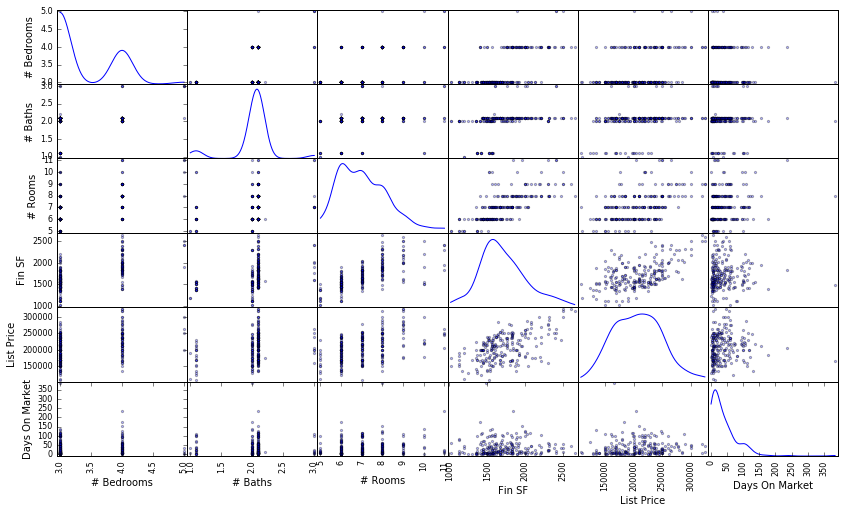

In [9]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

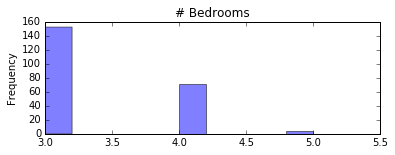

# Bedrooms does not follow a normal distribution


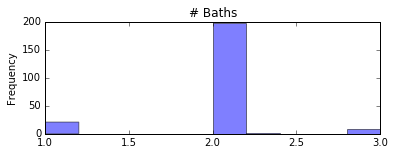

# Baths does not follow a normal distribution


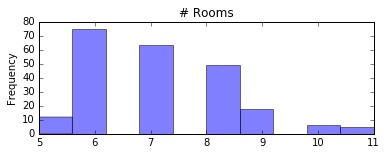

# Rooms does not follow a normal distribution


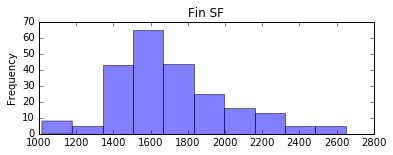

Fin SF does not follow a normal distribution


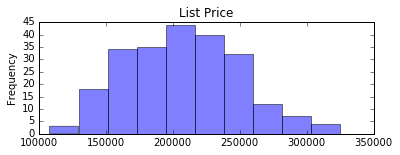

List Price does follow a normal distribution


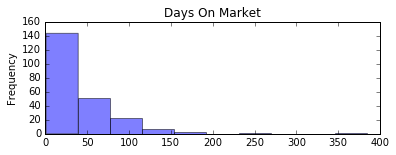

Days On Market does not follow a normal distribution


In [10]:
import scipy.stats as stats

for c in features.columns:
    x = data[c]
    x.plot(kind='hist', alpha=0.5, figsize = (6,2), title=c)
    plt.show()
    z,pvalue = stats.normaltest(x)
    isnormal = 'does' if pvalue > 0.055 else "does not"
    print "{} {} follow a normal distribution".format(c, isnormal)

#### Observations: 

It appears none of the features except for List Price follows a normal distribution.  This means we will need to implement feature scaling.  

C:\Users\jlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Users\jlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\seaborn\linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


                # Bedrooms   # Baths   # Rooms    Fin SF  List Price  \
# Bedrooms        1.000000  0.320225  0.556835  0.639936    0.379777   
# Baths           0.320225  1.000000  0.263700  0.350673    0.253025   
# Rooms           0.556835  0.263700  1.000000  0.708415    0.477294   
Fin SF            0.639936  0.350673  0.708415  1.000000    0.570876   
List Price        0.379777  0.253025  0.477294  0.570876    1.000000   
Days On Market    0.055766 -0.013603  0.175445  0.024580    0.046355   
Target            0.110384  0.032654  0.143204  0.171204    0.249082   

                Days On Market    Target  
# Bedrooms            0.055766  0.110384  
# Baths              -0.013603  0.032654  
# Rooms               0.175445  0.143204  
Fin SF                0.024580  0.171204  
List Price            0.046355  0.249082  
Days On Market        1.000000  0.212107  
Target                0.212107  1.000000  


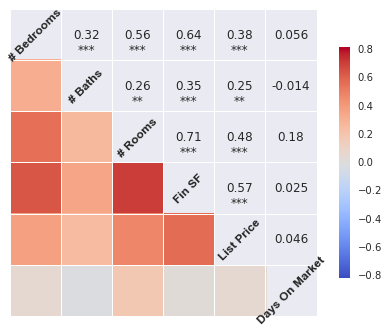

In [11]:
print data.corr(method='pearson')
import seaborn as sns
_ = sns.corrplot(features)

#### Observations: 
    
All the features are positively correlated with one another except for # Baths and Days on Market.  # Baths and Days on Market has a small negative correlation value of -0.014.  The correlation value is so small that one can conclude there is significant relationship between # Baths and Days on Market.  The other correlation make a lot of sense.  We should expect # Rooms to be highly correlated with # Bedrooms and # Baths since # Rooms is the sum of number of bedrooms, bathrooms, and other rooms a home has.  Rooms take up space so logically more rooms means more Fin SF.  Bedrooms are usually larger than bathrooms.  You can see the relationship between FIN SF and # Bedrooms is stronger than the relationship between FIN SF and # Bedrooms.  There does not appear to be any significant relationship between Days on Market and the other features except for # Rooms.  Homes with more rooms take slightly longer to sell.            

### Implementation: Feature Scaling

The data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew). It is most often appropriate to apply non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a Box-Cox test, which calculates the best power transformation of the data that reduces skewness. A simpler approach which will work in most cases would be applying the natural logarithm.  Feature scaling needs to be perform, because some of the regression models we’re using such as linear regression require the data follows a normal distribution to work properly.   

In [12]:
features = features.apply(np.log)

## Training and Evaluating Models
In this section, we will tried various supervised learning models that are available in `scikit-learn`.  We tested the models againist one model, and select the best model.  Then, we will fine tune our best model, and use it to make predictions.  

### Implementation: Define a Performance Metric

This is a regression problem rather than a classification because the values we are trying to predict are continuous rather than discrete.  Therefore, we should only consider performance metrics for regression problems.  Normally, r^2 is a good general metric to use in a situation like this.  However, r^2 uses some assumptions about the linearity of effects in the model; explained variance score might be more appropriate if you don't expect the models to be linear in most cases (for example, SVMs, nearest neighbors, or neural nets).  This metric is more fitting than r^2 because I will be using nonlinear models such as SVMs and nearest neighbors to solve my problem. 

Explained Variance Score compares the residual variance against the total variance of your dataset.  The residual variance will be less than or equal to the total variance of the dataset.  No residual variance means your model explains the dataset perfectly since there is no difference between your predicted target values and the actual target values.  A residual variance equal to the total variance means your model does not explain the data at all.  The explained variance score is 1 minus the ratio of the residual variance and total variance which is between zero and one.  Therefore, the higher the score, the more the model explains the data.       

In [13]:
from sklearn.metrics import explained_variance_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = explained_variance_score(y_true, y_predict) 
    
    # Return the score
    return score

### Implementation: Training and Testing Data Split
We need to split the data into training and testing sets to estimate how our model will perform on new data. This will also check to see if we are overfitting model to the data. An over fitted model will perform well on the training set but poorly on the testing set.  We will use 200 data points for training our model.  Then we will test our models on the remaining data points.  

In [14]:
from sklearn.cross_validation import train_test_split

num_all = data.shape[0]
num_train = 200
num_test = num_all - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 1. * num_test/num_all, random_state=0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 200 samples.
Testing set has 29 samples.


In [15]:
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return performance_metric(target, y_pred)

def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "Performance score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "Performance score for test set: {}".format(predict_labels(clf, X_test, y_test))

### Implementation:  Choosing the Best Model

We will try various different regression models from Sklearn.  A regression model from each category was selected.  Essemble regressions were not considered due to the limited amount of data that we have.  

In [16]:
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

linear_models = [linear_model.LinearRegression(), 
              KernelRidge(alpha=1.0),
              svm.SVR(),
              linear_model.SGDRegressor(),    
              KNeighborsRegressor(n_neighbors=5),
              DecisionTreeRegressor()]

for model in linear_models:
    train_predict(model, X_train, y_train, X_test, y_test)
              

------------------------------------------
Training set size: 200
Training LinearRegression...
Done!
Training time (secs): 0.001
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.000
Performance score for training set: 0.0954831544834
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.000
Performance score for test set: 0.181391879412
------------------------------------------
Training set size: 200
Training KernelRidge...
Done!
Training time (secs): 0.005
Predicting labels using KernelRidge...
Done!
Prediction time (secs): 0.003
Performance score for training set: 0.0595059934826
Predicting labels using KernelRidge...
Done!
Prediction time (secs): 0.000
Performance score for test set: 0.164951989561
------------------------------------------
Training set size: 200
Training SVR...
Done!
Training time (secs): 0.001
Predicting labels using SVR...
Done!
Prediction time (secs): 0.001
Performance score for training set: 0.000710364706033
Pr

#### Observations:

All the regression model other than the Decision Tree Regressor achieved a positive explained variance score.  The Decision Tree has a perfect score on training data set but it failed on the training set.  This is definitely a case of overfitting.  Other regression models such as Linear, Kernel Ridge, and SGD did significantly better on the testing data vs. on the training model.  Training performance should be better than testing performance, because the model is optimized and fitted to the training data.  The models are suffering from high bias as the models are not really learning from the data.  The K-NN Regressor achieved the highest explained variance score among all these estimators.  It achieved an explained variance of 0.2121 in the training set and 0.2401 in the testing set.  These two scores are almost identical which is really good.  The model is able to explain both sets of data equally well.  

### Implementation: Model Tuning

We will use fine tune the best our model by using grid search to find the best hyperparameters.  We will search for the optimal number of neighbors   

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import grid_search
from sklearn.metrics import make_scorer

from sklearn.neighbors import KNeighborsRegressor
from sklearn import grid_search

parameters = [{'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 10)}]
grid = grid_search.GridSearchCV(KNeighborsRegressor(), param_grid = parameters)

In [18]:
train_predict(grid, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 200
Training GridSearchCV...
Done!
Training time (secs): 0.206
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
Performance score for training set: 0.136420659587
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001
Performance score for test set: 0.211756478074


In [19]:
grid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform')

### Observations:

The optimal n_neighbors was 9 and the optimal settings for weight was uniform.  Unfortunately, our fine-tuned model performed slightly worse than the model with default parameters.  It achieved an explained variance score of 0.2117 which is less than our original score of 0.2401.  An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data.   

### Predicting Selling Prices

We are trying to use the fine-tuned model to predict how much room my friend has to negotiate the sales price of the home.  The house had 4 bedrooms, 2.5 baths, 7 rooms, and is 2,088 fin sf in size.  The home was listed for $195,000 and had been on the market for 43 days.  We need to transform our input by applying the natural logarithm.

In [20]:
# Bedrooms	# Baths	# Rooms	Fin SF	List Price	Days On Market	Target
inputs = np.array([4, 2.5, 2088, 7, 43, 195000])
grid.predict(np.log(inputs))

C:\Users\jlee\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 3305.55555556])

#### Observations:

The model predicts that my friend has about $3305 to work with.  It suggests that she should place an offer for that home at $191,695.

## Conclusion

### Reflection
We started out by preprocessing the data before we did any type analysis.  Invalid data points and outliers were removed from the data set.  Our analysis showed us that each feature was relevant and not exclude any of them from our model.  We also discovered that most of the features were not normally so we had to log feature scaling to normalize them.  Afterwards, we tried many different regression model and found out none of them worked really well.  The variance score for an assortment of estimators I tried were all very low.  

My friend did follow the recommendation from the model.  There is a happy ending here as she end up getting this particular house. However, I don't think the model contributed a lot to her success due to the many shortcomings that I have mentioned.    


### Improvement
The biggest improvement would be getting more and better data.  The fact that many different regression failed means the data set is not very good.  I would like to try this approach on more homes to see the results are any better.  I need to find a free API that has the data I’m looking for. I need to be able to systemically get the recent sales data around x mile radius of the home I’m looking at.  The data right now is gathered and compiled by manually by hand.  This makes such a task infeasible.      
